In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('champagne.csv', header=0)
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


In [3]:
df = df.rename(columns={'Perrin Freres monthly champagne sales millions ?64-?72':'Sales'})

In [4]:
df.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


In [6]:
df.count()

Month    105
Sales    105
dtype: int64

In [7]:
df.isnull().sum()

Month    0
Sales    0
dtype: int64

In [8]:
df['Month'] = pd.to_datetime(df['Month'])

In [10]:
df.dtypes

Month    datetime64[ns]
Sales             int64
dtype: object

In [11]:
df.set_index('Month',inplace=True)

In [12]:
df.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [13]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Sales,105.0,4761.152381,2553.502601,1413.0,3113.0,4217.0,5221.0,13916.0


# Step 2: Visualize the Data

Let's visualize this data with a few methods


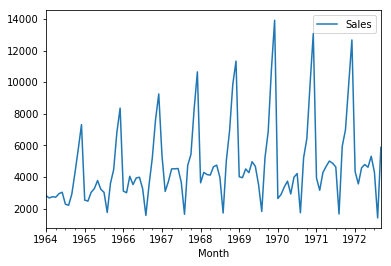

In [14]:
df.plot()

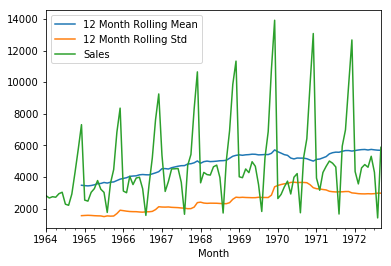

In [15]:
timeseries = df['Sales']
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')
timeseries.plot()
plt.legend()

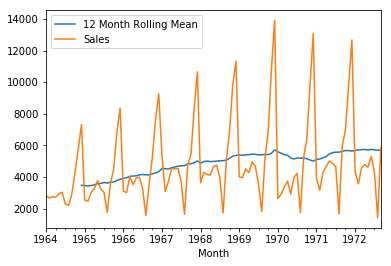

In [16]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.plot()
plt.legend()

# Decomposition¶

ETS decomposition allows us to see the individual parts!


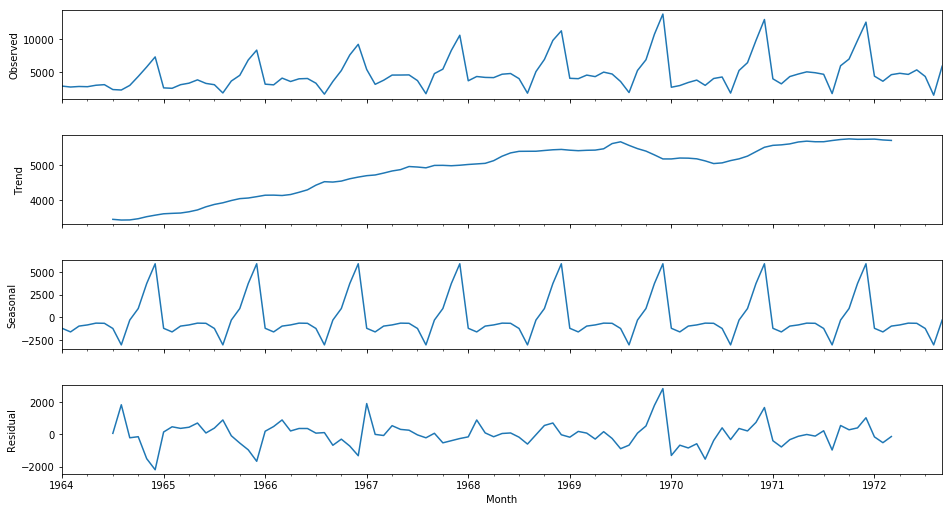

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Sales'], freq=12) 
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [22]:
# Store in a function for later use!
from statsmodels.tsa.stattools import adfuller
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [23]:
adf_check(df['Sales'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.83359305633
p-value : 0.36391577166
#Lags Used : 11
Number of Observations Used : 93
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


# Differencing

The first difference of a time series is the series of changes from one period to the next. We can do this easily with pandas. You can continue to take the second difference, third difference, and so on until your data is stationary.

#### First Difference 

In [24]:
df['First_diff'] = df['Sales'] -  df['Sales'].shift(1)
df['First_diff'].head()

Month
1964-01-01      NaN
1964-02-01   -143.0
1964-03-01     83.0
1964-04-01    -34.0
1964-05-01    225.0
Name: First_diff, dtype: float64

In [25]:
#Test Stationarity
adf_check(df['First_diff'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -7.18989644805
p-value : 2.51962044739e-10
#Lags Used : 11
Number of Observations Used : 92
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


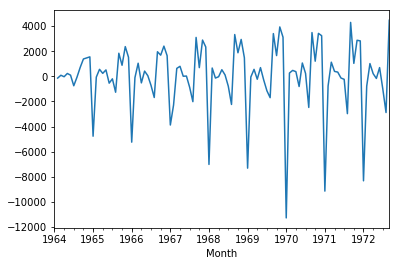

In [26]:
df['First_diff'].plot()

In [27]:
df['Seasonal'] = df['Sales'] - df['Sales'].shift(12)
df['Seasonal'].head()

Month
1964-01-01   NaN
1964-02-01   NaN
1964-03-01   NaN
1964-04-01   NaN
1964-05-01   NaN
Name: Seasonal, dtype: float64

In [28]:
adf_check(df['Seasonal'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -7.62661915721
p-value : 2.06057969681e-11
#Lags Used : 0
Number of Observations Used : 92
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


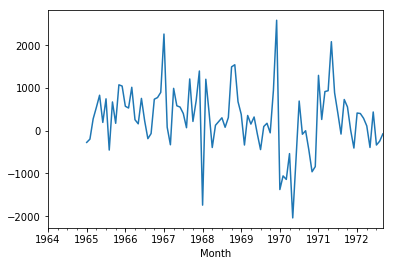

In [29]:
df['Seasonal'].plot()

# Autocorrelation and Partial Autocorrelation Plots

#### Autocorrelation Interpretation

The actual interpretation and how it relates to ARIMA models can get a bit complicated, but there are some basic common methods we can use for the ARIMA model. Our main priority here is to try to figure out whether we will use the AR or MA components for the ARIMA model (or both!) as well as how many lags we should use. In general you would use either AR or MA, using both is less common.

•If the autocorrelation plot shows positive autocorrelation at the first lag (lag-1), then it suggests to use the AR terms in relation to the lag


•If the autocorrelation plot shows negative autocorrelation at the first lag, then it suggests using MA terms



_____
### <font color='red'> Important Note! </font> 

Here we will be showing running the ACF and PACF on multiple differenced data sets that have been made stationary in different ways, typically you would just choose a single stationary data set and continue all the way through with that.

The reason we use two here is to show you the two typical types of behaviour you would see when using ACF.
_____

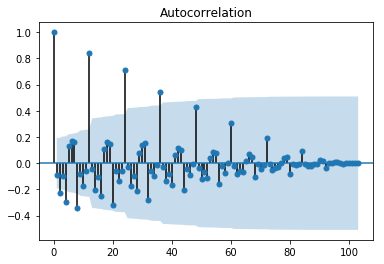

In [30]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig_first =plot_acf(df['First_diff'].dropna())

C:\ProgramData\Anaconda3\envs\tfdeeplearning\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


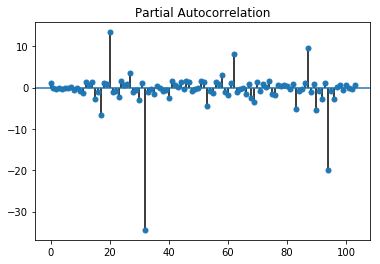

In [31]:
result = plot_pacf(df['First_diff'].dropna())

# Final ACF and PACF Plots

C:\ProgramData\Anaconda3\envs\tfdeeplearning\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


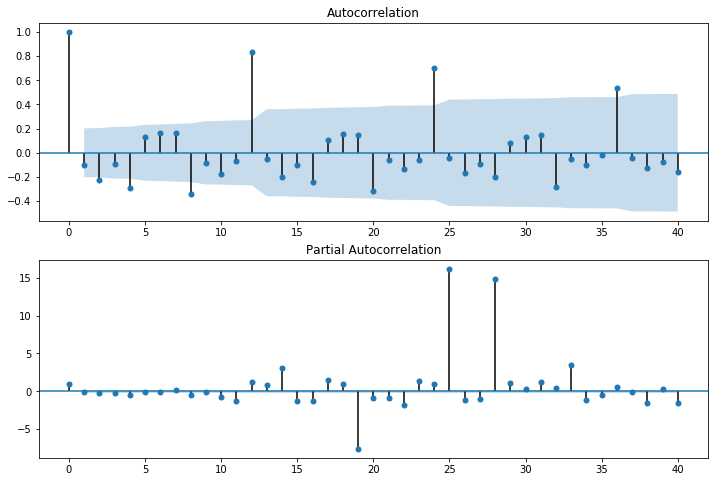

In [32]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['First_diff'].iloc[11:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['First_diff'].iloc[11:], lags=40, ax=ax2)

In [39]:
model = sm.tsa.statespace.SARIMAX(df['Sales'],order=(0,1,1), seasonal_order=(0,1,1,12))
results = model.fit()
print(results.summary())

C:\ProgramData\Anaconda3\envs\tfdeeplearning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  105
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -742.258
Date:                            Mon, 01 Oct 2018   AIC                           1490.517
Time:                                    22:14:12   BIC                           1498.082
Sample:                                01-01-1964   HQIC                          1493.570
                                     - 09-01-1972                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8858      0.048    -18.535      0.000      -0.979      -0.792
ma.S.L12      -0.1635      0.077   

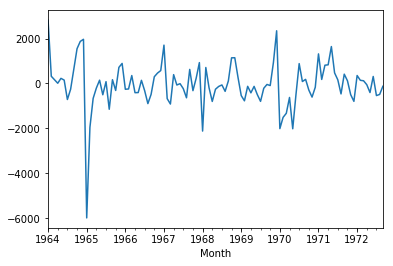

In [40]:
results.resid.plot()

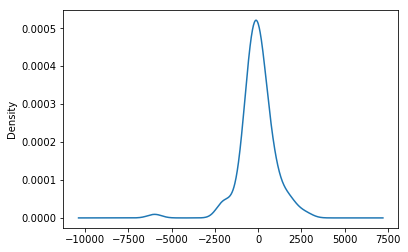

In [41]:
results.resid.plot(kind='kde')

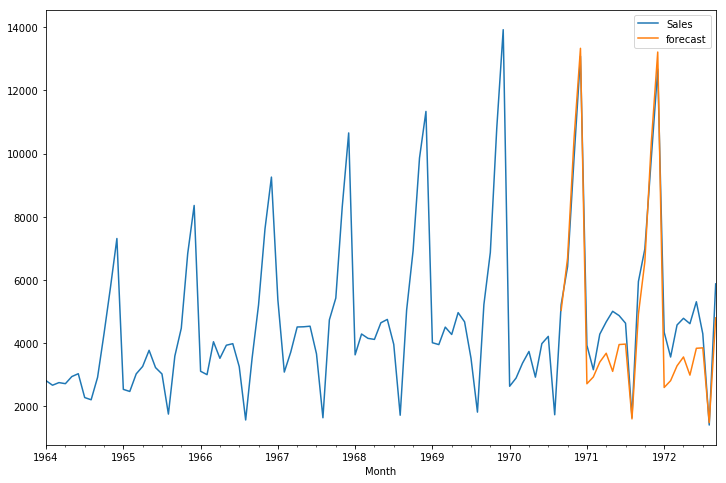

In [48]:
df['forecast'] = results.predict(start = 80, end= 130, dynamic= True)  
df[['Sales','forecast']].plot(figsize=(12,8))